In [1]:
import os
import Myloss
import dataloader
from modeling import model
import torch.optim
from modeling.fpn import *
# from option import *
from utils import *
from comp_ssim import *
import torch.nn as nn
import matplotlib.pyplot as plt

os.environ['CUDA_VISIBLE_DEVICES'] = '0' # GPU only
device = get_device()



/usr/local/lib/python3.8/dist-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.8/dist-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/usr/local/lib/python3.8/dist-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.8/dist-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [2]:
class Trainer():
    def __init__(self):
        # General Parameters
        lr = 0.0001
        weight_decay = 0.0001
        grad_clip_norm = 0.1
        num_epochs = 100
        train_batch_size = 6
        val_batch_size = 8
        num_workers = 4
        display_iter = 10
        snapshot_iter = 10
        scale_factor = 1
        num_of_SegClass = 21  # Number of Segmentation Classes, default VOC = 21

        # Weight Parameters
        lowlight_images_path = "low/"
        highlight_images_path = "high/"
        snapshots_folder = "weight/"
        load_pretrain = False
        pretrain_dir = "./weight/NOX.pth"

        # Ablation Parameters
        conv_type = "dsc"  # 선택: 'dsc', 'dc', 'tc'
        patch_size = 4  # 선택: 3, 4, 5
        exp_level = 0.6  # 선택: 0.5, 0.6, 0.7

        ### Testing Settings
        weight_dir = 'weight/Epoch99.pth'  
        test_dir = 'test_output'  
        input_dir = 'data/test_data/'  

        self.scale_factor = scale_factor
        self.net = model.enhance_net_nopool(self.scale_factor, conv_type=conv_type).to(device)
        self.seg = fpn(num_of_SegClass).to(device)
        self.seg_criterion = FocalLoss(gamma=2).to(device)
        self.train_dataset = dataloader.low_high_light_loader(lowlight_images_path, highlight_images_path)
        self.train_loader = torch.utils.data.DataLoader(self.train_dataset,
                                                        batch_size=train_batch_size,
                                                        shuffle=True,
                                                        num_workers=num_workers,
                                                        pin_memory=True)
        self.L_color = Myloss.L_color()
        self.L_spa = Myloss.L_spa8(patch_size=patch_size)
        self.L_exp = Myloss.L_exp(16)
        self.L_TV = Myloss.L_TV()
        self.L_MSE = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=lr, weight_decay=weight_decay)

        self.num_epochs = num_epochs
        self.E = exp_level
        self.grad_clip_norm = grad_clip_norm
        self.display_iter = display_iter
        self.snapshot_iter = snapshot_iter
        self.snapshots_folder = snapshots_folder

        if load_pretrain:
            self.net.load_state_dict(torch.load(pretrain_dir, map_location=device))
            print("Pretrained weight loaded successfully.")

        # 그래프 관련 변수 초기화
        self.losses = []
        self.avg_ssims = []


    def get_seg_loss(self, enhanced_image):
        # segment the enhanced image
        seg_input = enhanced_image.to(device)
        seg_output = self.seg(seg_input).to(device)

        # build seg output
        target = (get_NoGT_target(seg_output)).data.to(device)

        # calculate seg. loss
        seg_loss = self.seg_criterion(seg_output, target)

        return seg_loss

    # def get_loss(self, A, enhanced_image, img_lowlight, E, 정답데이터):
    def get_loss(self, A, enhanced_image, img_lowlight, E, highlight_image):
        Loss_TV = 1600 * self.L_TV(A)
        loss_spa = torch.mean(self.L_spa(enhanced_image, img_lowlight))
        loss_col = 5 * torch.mean(self.L_color(enhanced_image))
        loss_exp = 10 * torch.mean(self.L_exp(enhanced_image, E))
        loss_seg = self.get_seg_loss(enhanced_image)
        # MSE_loss 함수 추가
        loss_mse = self.L_MSE(enhanced_image, highlight_image)
        loss = Loss_TV + loss_spa + loss_col + loss_exp + 0.1 * loss_seg + 1e4 * loss_mse

        return loss


    def train(self):
        self.net.train()
        for epoch in range(self.num_epochs):
            ssim_list = []
            epoch_losses = []

            for iteration, (img_lowlight, img_highlight) in enumerate(self.train_loader):
                img_lowlight = img_lowlight.to(device)
                img_highlight = img_highlight.to(device)
                enhanced_image, A = self.net(img_lowlight)
                loss = self.get_loss(A, enhanced_image, img_lowlight, self.E, img_highlight)

                self.optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.net.parameters(), self.grad_clip_norm)
                self.optimizer.step()

                ssim_score = compare_ssim(enhanced_image, img_highlight)
                ssim_list.append(ssim_score)
                epoch_losses.append(loss.item())
                
                if ((iteration + 1) % self.display_iter) == 0:
                    print(f"Epoch : {epoch}, Loss at iteration", iteration + 1, ":", round(loss.item(), 4))

                if ((iteration + 1) % self.snapshot_iter) == 0:
                    torch.save(self.net.state_dict(), f"{self.snapshots_folder}Epoch{epoch}.pth")

            # 에포크별 평균 손실과 SSIM 저장
            average_loss = sum(epoch_losses) / len(epoch_losses)
            average_ssim = sum(ssim_list) / len(ssim_list)
            self.losses.append(average_loss)
            self.avg_ssims.append(average_ssim)

            print(f"Epoch {epoch+1}/{self.num_epochs}, Average Loss: {average_loss:.4f}, Average SSIM: {average_ssim:.4f}")

        # 학습 종료 후 손실 및 SSIM 그래프 그리기
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(self.losses, label='Loss')
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.avg_ssims, label='Average SSIM')
        plt.title('Average SSIM')
        plt.xlabel('Epoch')
        plt.ylabel('SSIM')
        plt.legend()

        plt.show()


Total training examples: 485


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:3736: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Epoch : 0, Loss at iteration 10 : 1500.458
Epoch : 0, Loss at iteration 20 : 1545.2415
Epoch : 0, Loss at iteration 30 : 1992.5232
Epoch : 0, Loss at iteration 40 : 1206.6171
Epoch : 0, Loss at iteration 50 : 1545.389
Epoch : 0, Loss at iteration 60 : 1390.0315
Epoch : 0, Loss at iteration 70 : 1634.0437
Epoch : 0, Loss at iteration 80 : 1106.2709
Epoch 1/100, Average Loss: 1384.6213, Average SSIM: 0.2278
Epoch : 1, Loss at iteration 10 : 1019.2266
Epoch : 1, Loss at iteration 20 : 661.4971
Epoch : 1, Loss at iteration 30 : 628.4564
Epoch : 1, Loss at iteration 40 : 991.5669
Epoch : 1, Loss at iteration 50 : 601.5607
Epoch : 1, Loss at iteration 60 : 1144.1517
Epoch : 1, Loss at iteration 70 : 879.1697
Epoch : 1, Loss at iteration 80 : 558.4492
Epoch 2/100, Average Loss: 809.3023, Average SSIM: 0.5184
Epoch : 2, Loss at iteration 10 : 597.8678
Epoch : 2, Loss at iteration 20 : 228.6644
Epoch : 2, Loss at iteration 30 : 200.8794
Epoch : 2, Loss at iteration 40 : 402.3933
Epoch : 2, Loss

Epoch : 20, Loss at iteration 30 : 315.4325
Epoch : 20, Loss at iteration 40 : 391.5263
Epoch : 20, Loss at iteration 50 : 295.4475
Epoch : 20, Loss at iteration 60 : 463.8876
Epoch : 20, Loss at iteration 70 : 249.7261
Epoch : 20, Loss at iteration 80 : 197.5487
Epoch 21/100, Average Loss: 326.5975, Average SSIM: 0.6280
Epoch : 21, Loss at iteration 10 : 231.3715
Epoch : 21, Loss at iteration 20 : 494.9295
Epoch : 21, Loss at iteration 30 : 394.8771
Epoch : 21, Loss at iteration 40 : 230.5021
Epoch : 21, Loss at iteration 50 : 504.0161
Epoch : 21, Loss at iteration 60 : 579.0322
Epoch : 21, Loss at iteration 70 : 522.3255
Epoch : 21, Loss at iteration 80 : 256.73
Epoch 22/100, Average Loss: 323.9697, Average SSIM: 0.6344
Epoch : 22, Loss at iteration 10 : 520.1905
Epoch : 22, Loss at iteration 20 : 208.5396
Epoch : 22, Loss at iteration 30 : 301.1
Epoch : 22, Loss at iteration 40 : 285.3209
Epoch : 22, Loss at iteration 50 : 217.8904
Epoch : 22, Loss at iteration 60 : 250.3358
Epoch :

Epoch : 40, Loss at iteration 40 : 368.6429
Epoch : 40, Loss at iteration 50 : 331.9095
Epoch : 40, Loss at iteration 60 : 296.6776
Epoch : 40, Loss at iteration 70 : 131.5616
Epoch : 40, Loss at iteration 80 : 107.7324
Epoch 41/100, Average Loss: 307.6004, Average SSIM: 0.6402
Epoch : 41, Loss at iteration 10 : 577.4316
Epoch : 41, Loss at iteration 20 : 373.347
Epoch : 41, Loss at iteration 30 : 244.2833
Epoch : 41, Loss at iteration 40 : 200.3131
Epoch : 41, Loss at iteration 50 : 359.9997
Epoch : 41, Loss at iteration 60 : 161.8166
Epoch : 41, Loss at iteration 70 : 103.9916
Epoch : 41, Loss at iteration 80 : 768.7521
Epoch 42/100, Average Loss: 307.2775, Average SSIM: 0.6241
Epoch : 42, Loss at iteration 10 : 288.4001
Epoch : 42, Loss at iteration 20 : 157.6662
Epoch : 42, Loss at iteration 30 : 351.4794
Epoch : 42, Loss at iteration 40 : 499.3185
Epoch : 42, Loss at iteration 50 : 571.7968
Epoch : 42, Loss at iteration 60 : 205.7023
Epoch : 42, Loss at iteration 70 : 251.7618
Epo

Epoch : 60, Loss at iteration 40 : 400.4823
Epoch : 60, Loss at iteration 50 : 318.72
Epoch : 60, Loss at iteration 60 : 589.7651
Epoch : 60, Loss at iteration 70 : 168.384
Epoch : 60, Loss at iteration 80 : 207.1667
Epoch 61/100, Average Loss: 297.2571, Average SSIM: 0.6334
Epoch : 61, Loss at iteration 10 : 92.7513
Epoch : 61, Loss at iteration 20 : 354.2944
Epoch : 61, Loss at iteration 30 : 174.509
Epoch : 61, Loss at iteration 40 : 209.7093
Epoch : 61, Loss at iteration 50 : 450.327
Epoch : 61, Loss at iteration 60 : 426.3741
Epoch : 61, Loss at iteration 70 : 380.8576
Epoch : 61, Loss at iteration 80 : 463.1467
Epoch 62/100, Average Loss: 296.2135, Average SSIM: 0.6420
Epoch : 62, Loss at iteration 10 : 237.6867
Epoch : 62, Loss at iteration 20 : 263.1817
Epoch : 62, Loss at iteration 30 : 148.8602
Epoch : 62, Loss at iteration 40 : 243.673
Epoch : 62, Loss at iteration 50 : 483.4066
Epoch : 62, Loss at iteration 60 : 577.5484
Epoch : 62, Loss at iteration 70 : 425.5227
Epoch : 6

Epoch : 80, Loss at iteration 40 : 137.5132
Epoch : 80, Loss at iteration 50 : 709.8019
Epoch : 80, Loss at iteration 60 : 132.6279
Epoch : 80, Loss at iteration 70 : 159.5496
Epoch : 80, Loss at iteration 80 : 225.226
Epoch 81/100, Average Loss: 286.3262, Average SSIM: 0.6401
Epoch : 81, Loss at iteration 10 : 263.0331
Epoch : 81, Loss at iteration 20 : 238.2277
Epoch : 81, Loss at iteration 30 : 193.6898
Epoch : 81, Loss at iteration 40 : 714.7449
Epoch : 81, Loss at iteration 50 : 133.9253
Epoch : 81, Loss at iteration 60 : 121.0646
Epoch : 81, Loss at iteration 70 : 708.979
Epoch : 81, Loss at iteration 80 : 230.1615
Epoch 82/100, Average Loss: 286.0786, Average SSIM: 0.6237
Epoch : 82, Loss at iteration 10 : 262.9632
Epoch : 82, Loss at iteration 20 : 281.6214
Epoch : 82, Loss at iteration 30 : 300.2962
Epoch : 82, Loss at iteration 40 : 493.1855
Epoch : 82, Loss at iteration 50 : 179.3454
Epoch : 82, Loss at iteration 60 : 437.6501
Epoch : 82, Loss at iteration 70 : 172.3876
Epoc

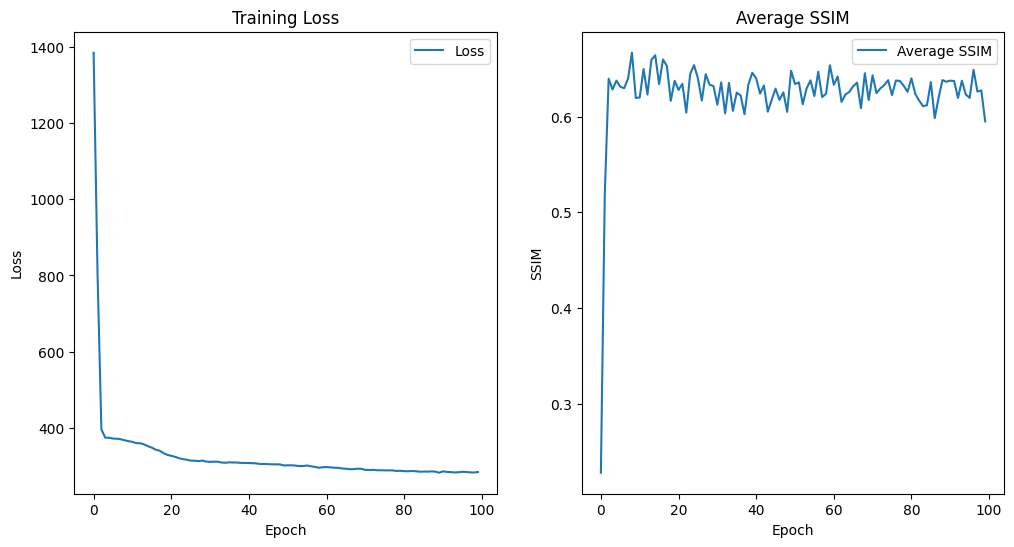

In [3]:
t = Trainer()
t.train()